In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from scipy.optimize import fsolve

In [24]:
# Input Data 

# CAPEX Components
SOFC_cost = 720000  # 6000 €/kW × 120 kW
cleanup_cost = 60000  # 500 €/kW × 120 kW  
thermal_cost = 41755  # Scaled: 50000 * (66.65/90)^0.6
construction_cost = 122400  # 17% of total CAPEX
CAPEX_total = SOFC_cost + cleanup_cost + thermal_cost + construction_cost

# OPEX Components
cleanup_cost_annual_per_kwhe = 0.5  # c€/kWhe
general_OM = 0.05 * CAPEX_total  # 5% of CAPEX
catalyst_cost = 500*33.41/60  # Annual
stack_replacement = 0.35 * SOFC_cost  # Every 5 years: 252,000 €
labour_cost = 20 *52 * 24  # 20 h/week × 52 weeks × 24 €/h = 24,960 €/year


# Energy Production & Economics
# System parameters
capacity_factor = 0.913
operating_hours = 8760 * capacity_factor  # hours/year
stack_replacement_years = [5, 10, 15, 20]

# Electrical output
W_DC_gross = 119.868 # kW (SOFC rated capacity) (From Aspen)
inverter_efficiency = 0.95
W_AC_gross = W_DC_gross * inverter_efficiency  # kW
Electrical_consumption_of_biogas_blower = 249.682/1000 # kW (Fron Aspen)
Electrical_consumption_of_air_blower = 2735.32/1000 # kW (Fron Aspen)
aux_consumption = Electrical_consumption_of_biogas_blower + Electrical_consumption_of_air_blower # kW
W_AC_net = W_AC_gross - aux_consumption  # kW
print(f"Net AC Power Output: {W_AC_net} kW")

# Total Installed capacity
SOFC_capacity_per_unit = 60 # kW
Number_of_units = math.ceil(W_DC_gross / (SOFC_capacity_per_unit))
print(f"Number of SOFC units required: {Number_of_units}")

# Thermal output
Out_let_temp = 90 + 273.15  # K
Total_heat_out = 66.6532 # kW (From Aspen)
Net_heat_available_for_consumption = Total_heat_out*0.4 # 60% heat is used as suggested 

# Economic parameters
electricity_price = 0.2336 # €/kWh
Distric_heating_price = 70 # €/MWh

# Financial parameters
project_lifetime = 20  # years
discount_rate = 0.08  # 8%

# WACC Calculation
equity_fraction = 0.3
debt_fraction = 0.7
cost_of_equity = 0.08 # 8%
cost_of_debt = 0.05 # 5%
tax_rate = 0.24 # 24%

cleanup_cost_annual= cleanup_cost_annual_per_kwhe * W_AC_net * operating_hours / 100  # Annual cleanup cost
print(f"Annual cleanup cost: {cleanup_cost_annual} €")
OPEX_annual = general_OM + catalyst_cost + labour_cost + cleanup_cost_annual  # Annual OPEX excluding stack replacement


Net AC Power Output: 110.88959799999999 kW
Number of SOFC units required: 2
Annual cleanup cost: 4434.408490261199 €


In [23]:
# Heating & Electricity Saving
Electricity_cost_saving = W_AC_net * operating_hours * electricity_price   # €/year
Heating_cost_saving = Net_heat_available_for_consumption * operating_hours * (Distric_heating_price / 1000)  # €/year
Total_annual_saving = Electricity_cost_saving + Heating_cost_saving
print(f"Annual Electricity Cost Saving: {Electricity_cost_saving} €")
print(f"Annual Heating Cost Saving: {Heating_cost_saving} €")
print(f"Total Annual Cost Saving: {Total_annual_saving} €")

# Print Summary
print(f"Total CAPEX: {CAPEX_total} €")
print(f"OPEX Annual: {OPEX_annual} €")
wacc = (equity_fraction * cost_of_equity) + (debt_fraction * cost_of_debt * (1 - tax_rate))  # Assuming 30% tax rate
print(f"WACC: {wacc*100:.2f}%")

# Depreciation parameters
depreciation_years = 10  # years
depreciation_rate = CAPEX_total / depreciation_years
print(f"Annual Depreciation: {depreciation_rate} €")

Annual Electricity Cost Saving: 207175.56466500324 €
Annual Heating Cost Saving: 14926.360266048003 €
Total Annual Cost Saving: 222101.92493105124 €
Total CAPEX: 944155 €
OPEX Annual: 76880.57515692785 €
WACC: 5.06%
Annual Depreciation: 94415.5 €


#### 2. Cash Flow Analysis

In [25]:
# Initialize arrays
years = np.arange(0, project_lifetime + 1)
cash_flow = np.zeros(project_lifetime + 1)
discounted_cash_flow = np.zeros(project_lifetime + 1)
cumulative_cash_flow = np.zeros(project_lifetime + 1)
incomes = np.zeros(project_lifetime + 1)
costs = np.zeros(project_lifetime + 1)
taxes = np.zeros(project_lifetime + 1)


# Year 0: Initial Investment
cash_flow[0] = -CAPEX_total
cumulative_cash_flow[0] = cash_flow[0]
discounted_cash_flow[0] = cash_flow[0]
print(f"Year 0: Initial Investment: {cash_flow[0]} €")

# Years 1-20: Operation
for year in range(1, project_lifetime + 1):
    # Incomes
    incomes[year] = Total_annual_saving
    costs[year] = OPEX_annual
    
    # Cost 
    costs[year] = OPEX_annual
    if year in stack_replacement_years:
        costs[year] += stack_replacement  # Stack replacement cost every 5 years

    # TAXES
    if year <= depreciation_years:
        taxable_income = incomes[year] - costs[year] - depreciation_rate
    else:
        taxable_income = incomes[year] - costs[year]
    
    if taxable_income > 0:
        taxes[year] = tax_rate * taxable_income
    else:
        taxes[year] = 0

    # Cash Flow
    cash_flow[year] = incomes[year] - costs[year] - taxes[year]

    # Discounted Cash Flow
    discounted_factor = 1 / ((1 + wacc) ** year)
    discounted_cash_flow[year] = cash_flow[year] * discounted_factor

    # Cumulative Cash Flow
    cumulative_cash_flow[year] = cumulative_cash_flow[year - 1] + discounted_cash_flow[year]

# Calculate NPV
NPV = cumulative_cash_flow[-1]
print(f"Net Present Value (NPV): {NPV} €")

Year 0: Initial Investment: -944155.0 €
Net Present Value (NPV): 80558.70950247989 €


In [26]:
# Calculate Payback Time
payback_time = None
for i in range(1, len(cumulative_cash_flow)):
    if cumulative_cash_flow[i-1] < 0 and cumulative_cash_flow[i] >= 0:
        n_y = i - 1
        CCF_ny = cumulative_cash_flow[n_y]
        CF_ny1 = discounted_cash_flow[i]
        payback_time = n_y + abs(CCF_ny) / CF_ny1
        break

# Calculate IRR
def npv_function(rate):
    return np.sum(cash_flow / ((1 + rate) ** years))

IRR = fsolve(npv_function, 0.1)[0]

print("CASH FLOW ANALYSIS RESULTS")
print(f"Net Present Value (NPV):  {NPV:>12,.0f} €")
print(f"Internal Rate of Return:  {IRR*100:>12,.2f} %")
if payback_time:
    print(f"Payback Time:             {payback_time:>12,.2f} years")
else:
    print(f"Payback Time:             {'Not within 20 years':>20}")
print("="*80)

# Create cash flow dataframe for reference
cf_data = pd.DataFrame({
    'Year': years,
    'Income (€)': incomes,
    'Costs (€)': costs,
    'Taxes (€)': taxes,
    'Cash Flow (€)': cash_flow,
    'DCF (€)': discounted_cash_flow,
    'Cumulative CF (€)': cumulative_cash_flow
})
print("\nSample Cash Flow (Selected Years):")
print(cf_data.iloc[[0, 1, 5, 10, 15, 20]].to_string(index=False))



CASH FLOW ANALYSIS RESULTS
Net Present Value (NPV):        80,559 €
Internal Rate of Return:          6.27 %
Payback Time:                    16.33 years

Sample Cash Flow (Selected Years):
 Year    Income (€)     Costs (€)    Taxes (€)  Cash Flow (€)        DCF (€)  Cumulative CF (€)
    0      0.000000      0.000000     0.000000 -944155.000000 -944155.000000     -944155.000000
    1 222101.924931  76880.575157 12193.403946  133027.945828  126620.926926     -817534.073074
    5 222101.924931 328880.575157     0.000000 -106778.650226  -83425.236090     -556526.427250
   10 222101.924931 328880.575157     0.000000 -106778.650226  -65179.415566     -253675.575244
   15 222101.924931 328880.575157     0.000000 -106778.650226  -50924.113766      -66039.631123
   20 222101.924931 328880.575157     0.000000 -106778.650226  -39786.569736       80558.709502


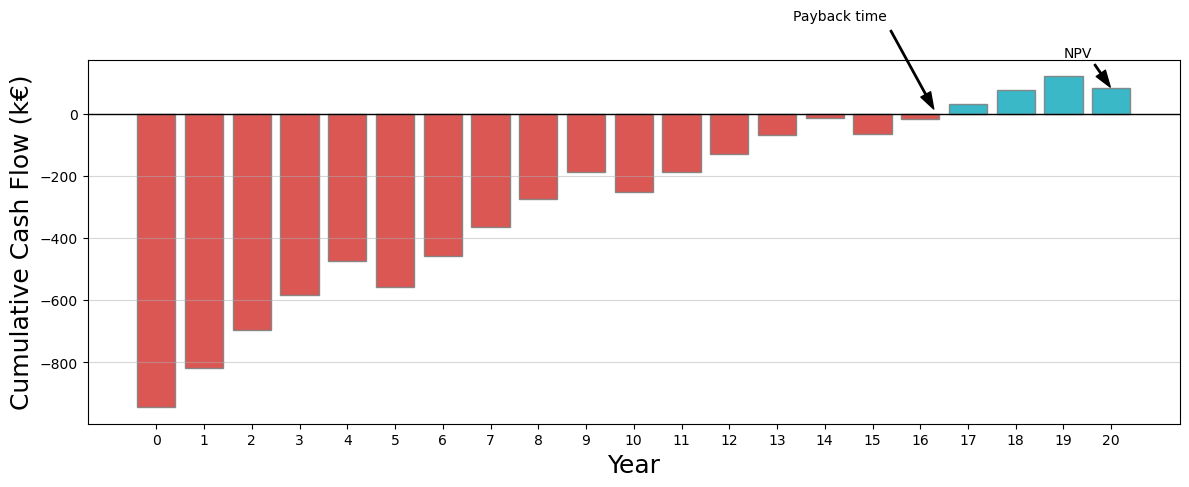

In [27]:
import matplotlib.pyplot as plt

# Set plot style
plt.figure(figsize=(12, 5))
colors = ['#d64541' if val < 0 else '#24b1c1' for val in cumulative_cash_flow]

# Create bar chart
bars = plt.bar(years, cumulative_cash_flow / 1e3, color=colors, edgecolor='grey', alpha=0.9)

# Formatting
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', linestyle='-', alpha=0.5)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Cumulative Cash Flow (k€)', fontsize=18)
# plt.title('Cumulative Cash Flow Turns Positive (Years 0-20)\nSOFC biogas project reaches payback around year 13.66', loc='left', fontsize=14)

# Add annotations for Payback and NPV
plt.annotate('Payback time', xy=(payback_time, 0), xytext=(payback_time-3, 300),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))
plt.annotate('NPV', xy=(20, NPV/1000), xytext=(19, NPV/1000 + 100),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8))

plt.xticks(years)
plt.tight_layout()
plt.show()

### 2.2 Sensitivity Analysis

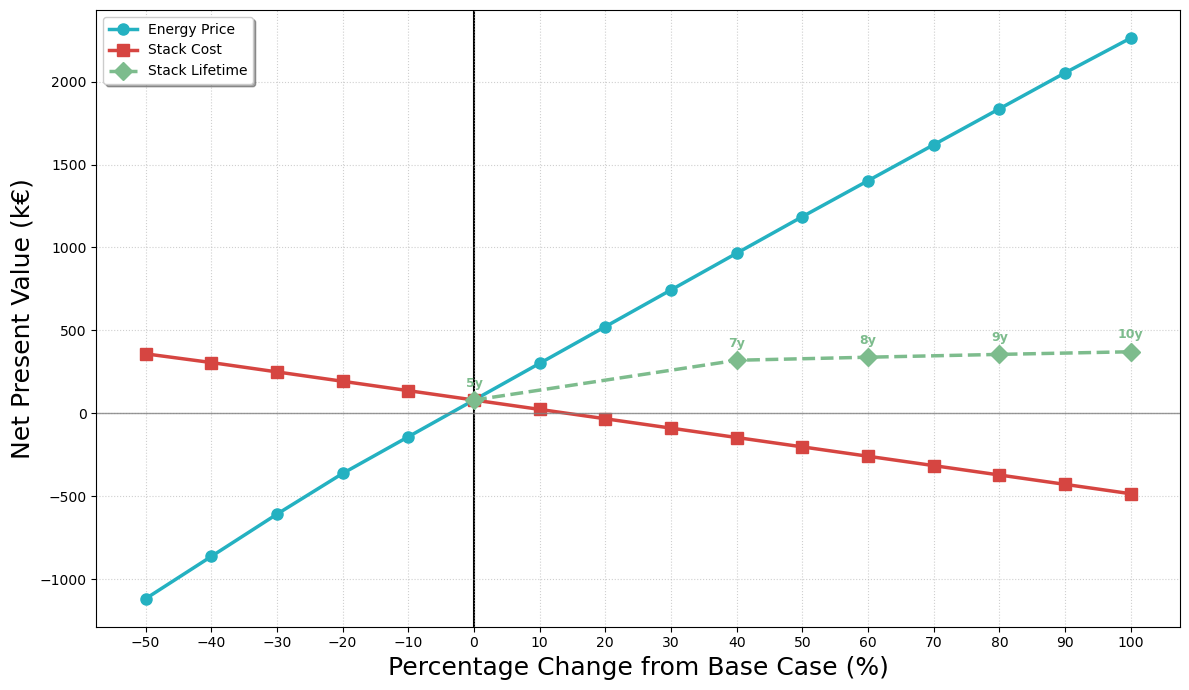

In [36]:
def run_simulation(energy_mult=1.0, stack_cost_mult=1.0, stack_life=5):
    """Economic simulation engine to calculate NPV."""
    stack_life = int(round(stack_life)) 
    if stack_life < 1: stack_life = 1
    
    # Identify stack replacement years
    replacement_years = [y for y in range(stack_life, project_lifetime + 1, stack_life) if y < project_lifetime + 1]
    
    discounted_cf = np.zeros(project_lifetime + 1)
    discounted_cf[0] = -CAPEX_total
    
    for year in range(1, project_lifetime + 1):
        cost = OPEX_annual + (stack_replacement * stack_cost_mult if year in replacement_years else 0)
        tax_shield = depreciation_rate if year <= depreciation_years else 0
        taxable_income = max(0, (Total_annual_saving * energy_mult) - cost - tax_shield)
        net_cf = (Total_annual_saving * energy_mult) - cost - (tax_rate * taxable_income)
        discounted_cf[year] = net_cf / ((1 + wacc) ** year)
        
    return np.sum(discounted_cf)

# --- 2. Generate Sensitivity Data ---
percents = np.arange(-50, 101, 10) 
life_milestones = np.array([5, 7, 8, 9, 10])
life_percents = (life_milestones - 5) / 5 * 100

npv_energy = [run_simulation(energy_mult=1 + p/100)/1000 for p in percents]
npv_cost = [run_simulation(stack_cost_mult=1 + p/100)/1000 for p in percents]
npv_life = [run_simulation(stack_life=y)/1000 for y in life_milestones]

# --- 3. Plotting ---
plt.figure(figsize=(12, 7))

# Plot lines with specified markers
plt.plot(percents, npv_energy, marker='o', color='#24b1c1', linewidth=2.5, markersize=8, label='Energy Price')
plt.plot(percents, npv_cost, marker='s', color='#d64541', linewidth=2.5, markersize=8, label='Stack Cost')
plt.plot(life_percents, npv_life, marker='D', color='#7dbc8d', linewidth=2.5, linestyle='--', markersize=9, label='Stack Lifetime')

# Anchor and Milestone Labels
plt.axvline(0, color='black', linewidth=1.5, linestyle='-', zorder=1)
plt.axhline(0, color='grey', linewidth=1, alpha=0.8)
for p, v, y in zip(life_percents, npv_life, life_milestones):
    plt.text(p, v + 80, f'{y}y', color='#7dbc8d', fontweight='bold', ha='center', fontsize=9)

# Formatting
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlabel('Percentage Change from Base Case (%)', fontsize=18)
plt.ylabel('Net Present Value (k€)', fontsize=18)
plt.xticks(np.arange(-50, 101, 10))
plt.legend(frameon=True, shadow=True, loc='best')
plt.tight_layout()
plt.show()

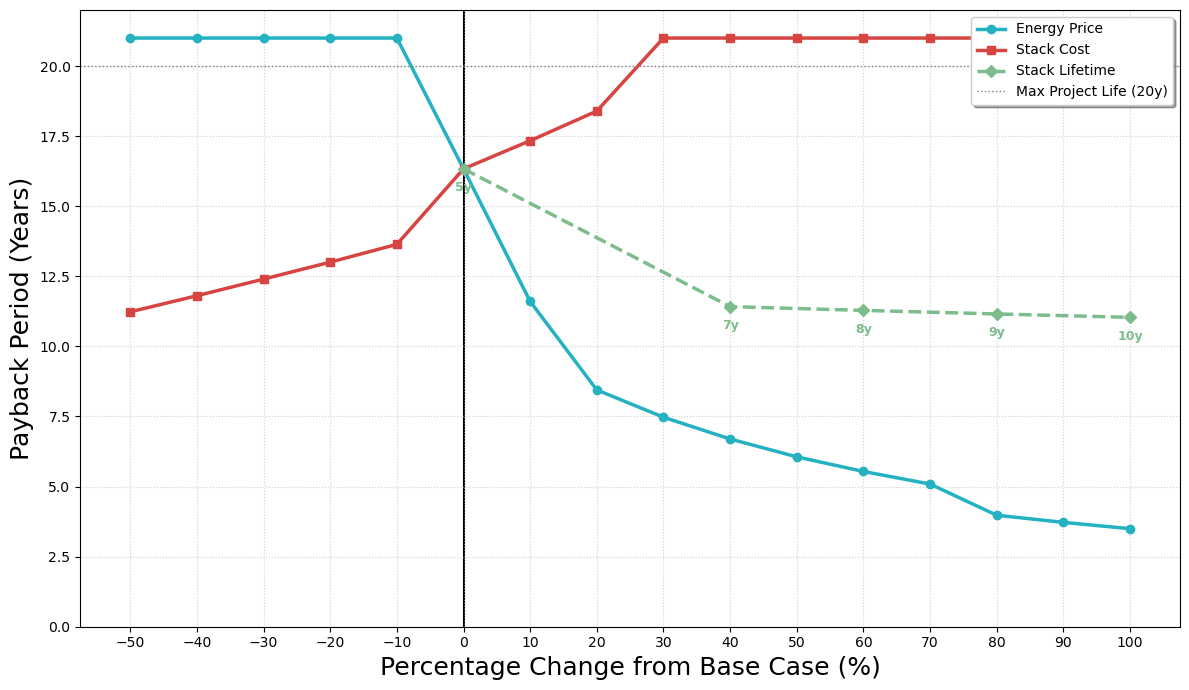

In [39]:

def run_simulation(energy_mult=1.0, stack_cost_mult=1.0, stack_life=5):
    """Economic simulation returning NPV and Payback Year."""
    stack_life = int(round(stack_life)) 
    if stack_life < 1: stack_life = 1
    
    # Identify stack replacement years
    replacement_years = [y for y in range(stack_life, project_lifetime + 1, stack_life) if y < project_lifetime + 1]
    
    discounted_cf = np.zeros(project_lifetime + 1)
    discounted_cf[0] = -CAPEX_total
    
    for year in range(1, project_lifetime + 1):
        cost = OPEX_annual + (stack_replacement * stack_cost_mult if year in replacement_years else 0)
        # Tax logic with 10-year depreciation shield
        tax_shield = depreciation_rate if year <= depreciation_years else 0
        taxable_income = max(0, (Total_annual_saving * energy_mult) - cost - tax_shield)
        net_cf = (Total_annual_saving * energy_mult) - cost - (tax_rate * taxable_income)
        discounted_cf[year] = net_cf / ((1 + wacc) ** year)
    
    cum_dcf = np.cumsum(discounted_cf)
    payback = None
    for i in range(1, len(cum_dcf)):
        if cum_dcf[i-1] < 0 and cum_dcf[i] >= 0:
            # Interpolation for exact payback moment
            payback = (i-1) + abs(cum_dcf[i-1]) / discounted_cf[i]
            break
    return np.sum(discounted_cf), payback

# 2. Calculating the variables with 10% steps
# Using np.arange for 10% step increments from -50% to +100%
percents_step10 = np.arange(-50, 101, 10) 
life_milestones = np.array([5, 7, 8, 9, 10])
life_percents = (life_milestones - 5) / 5 * 100

pb_energy = []
pb_cost = []
for p in percents_step10:
    _, pb_e = run_simulation(energy_mult=1 + p/100)
    _, pb_c = run_simulation(stack_cost_mult=1 + p/100)
    # If no payback within 20 years, cap at 21 for the plot
    pb_energy.append(pb_e if pb_e is not None else 21)
    pb_cost.append(pb_c if pb_c is not None else 21)

pb_life = []
for y in life_milestones:
    _, pb_l = run_simulation(stack_life=y)
    pb_life.append(pb_l if pb_l is not None else 21)

# 3. Generating the Plot
plt.figure(figsize=(12, 7))

# Plot lines with specified markers and labels
plt.plot(percents_step10, pb_energy, marker='o', color='#24b1c1', linewidth=2.5, label='Energy Price')
plt.plot(percents_step10, pb_cost, marker='s', color='#d64541', linewidth=2.5, label='Stack Cost')
plt.plot(life_percents, pb_life, marker='D', color='#7dbc8d', linewidth=2.5, linestyle='--', label='Stack Lifetime')

# Anchor and Threshold Visuals
plt.axvline(0, color='black', linewidth=1.5, zorder=1)
plt.axhline(20, color='grey', linewidth=1, linestyle=':', label='Max Project Life (20y)')
plt.ylim(0, 22) 

# Lifetime milestone text
for p, v, y in zip(life_percents, pb_life, life_milestones):
    if v <= 20:
        plt.text(p, v - 0.8, f'{y}y', color='#7dbc8d', fontweight='bold', ha='center', fontsize=9)

plt.grid(True, linestyle=':', alpha=0.6)
plt.xlabel('Percentage Change from Base Case (%)', fontsize=18)
plt.ylabel('Payback Period (Years)', fontsize=18)
plt.xticks(np.arange(-50, 101, 10)) # Set x-axis steps to 10
plt.legend(frameon=True, shadow=True, loc='upper right')

plt.tight_layout()
plt.show()